<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cleaner version of Circadian 6

## Ensembling

Testing Bulk data. We create a new dataframe that has the same columns as the bulk data. Then we test on the bulkdata (test data).

- With dropout, the model reached 92% on bulk data.
- Hihger accuracy on traning data does not necessarily mean high test accuracy.

### TODO
- Try ensembling:
  - With random seeds, there are too many variability in results.
  - Hopefully ensembling may provide better results
- Try data augmentation.
  - Random swap: swapping random columns.
- Try a new loss function.
  - Hexagon (7x8) with MSELoss
  1. Predict 56 outputs
  2. Create a hexagon
  3. MSE with the target
- Try Random Forest.
- Try Gradient boosting.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [2]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [3]:
import os
path = Path('data')

## Data

In [4]:
df = pd.read_csv(path/'RNA_norm.csv', index_col='cell', low_memory=False)

In [5]:
df.head()

,Meg3,Slc1a2,Rian,Cyp2c40,Cyp2c69,Sgcz,Glul,Ugt2b37,Tmeff2,B830012L14Rik,...,Mpp6,Ralgps1,Zfp580,Sept8,Cfap52,Arhgap27,F730043M19Rik,Bora,ZT,code
cell,,,,,,,,,,,,,,,,,,,,,
AAACAGCCAACCCTAA-6,-0.094012,-0.251429,-0.084206,-0.118838,-0.084834,-0.183315,-0.255395,-0.062888,-0.092432,-0.073209,...,1.122616,2.084872,-0.036734,-0.036734,-0.036734,-0.036734,-0.036734,-0.318222,ZT18,4
AAACCAACAGTAAAGC-6,-0.094012,-0.032904,-0.084206,-0.118838,-0.084834,-0.183315,-0.255395,-0.062888,-0.092432,-0.073209,...,-0.554376,-0.619790,-0.036734,-0.036734,-0.036734,-0.036734,-0.036734,2.058709,ZT18,4
AAACCGAAGGTCCTAG-6,-0.094012,-0.251429,-0.084206,-0.118838,-0.084834,-0.183315,-0.255395,-0.062888,-0.092432,-0.073209,...,0.451819,0.281764,-0.036734,-0.036734,-0.036734,-0.036734,-0.036734,-0.318222,ZT18,4
AAAGCACCATTGTCCT-6,-0.094012,-0.251429,-0.084206,-0.118838,-0.084834,-0.183315,-0.255395,-0.062888,-0.092432,-0.073209,...,0.451819,0.281764,-0.036734,-0.036734,-0.036734,-0.036734,-0.036734,-0.318222,ZT18,4
AAAGGACGTGAGGTGA-6,-0.094012,-0.251429,-0.084206,-0.118838,-0.084834,-0.183315,-0.255395,-0.062888,-0.092432,-0.073209,...,-0.889775,1.183318,-0.036734,-0.036734,-0.036734,-0.036734,-0.036734,-0.318222,ZT18,4


### Bulk + scRNA-seq

In [6]:
bulk_data = pd.read_csv(path/'bulk_data.csv', index_col='ID', low_memory=False)

In [7]:
df2 = pd.DataFrame(np.random.normal(size=(15992, 9482)), columns=bulk_data.columns)
df.reset_index(inplace=True)
df2.update(df)

## Using Pytorch

In [8]:
t_dep = tensor(df2['code'], dtype=torch.long)
indep_cols = list(df2.columns)[:-1]
t_indep = tensor(df2[indep_cols].values, dtype=torch.float32)

In [9]:
tst_dep = tensor(bulk_data['code'], dtype=torch.long)
tst_indep_cols = list(bulk_data.columns)[:-1]
tst_indep = tensor(bulk_data[indep_cols].values, dtype=torch.float32)

/tmp/ipykernel_280681/2800279189.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(bulk_data['code'], dtype=torch.long)


In [10]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df2)

In [11]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [12]:
bs = 128

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=4)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=4)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train

In [13]:
tst_dl = DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=4)

In [14]:
metrics = MetricsCB(accuracy=MulticlassAccuracy(device='cpu'))
astats = ActivationStats(nn.ReLU)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

## Data Augmentation

In [15]:
import random

In [16]:
def _random_swap(x):
    """Swap two columns randomly."""
    n_cols = x.shape[1]
    a = random.randint(0, n_cols-1)
    b = random.randint(0, n_cols-1)
    tmp = x[:,a].detach().clone()
    x[:,a] = x[:,b]
    x[:,b] = tmp
    return x

In [17]:
def random_swap(x, max_swaps=10):
    """Swap two columns randomly by picking a random number."""
    swaps = random.randint(0, 10)
    _random_swap(x)
    return x

In [18]:
class RandomSwap(nn.Module):
    def __init__(self, max_swaps=10):
        super().__init__()
        self.max_swaps = max_swaps

    def forward(self, x):
        return random_swap(x, self.max_swaps)

In [19]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [20]:
from functools import partial

In [21]:
tfms = nn.Sequential(RandomSwap(3000))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [22]:
def get_model():
    return nn.Sequential(*[nn.Linear(9481, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 6)])

In [23]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

accuracy,loss,epoch,train,time
0.551,1.452,0,True,00:00
0.770,0.958,0,False,00:00
0.908,0.494,1,True,00:00
0.956,0.282,1,False,00:00
0.993,0.109,2,True,00:00
0.964,0.164,2,False,00:00
1.000,0.034,3,True,00:00
0.965,0.135,3,False,00:00
1.000,0.017,4,True,00:00
0.964,0.123,4,False,00:00


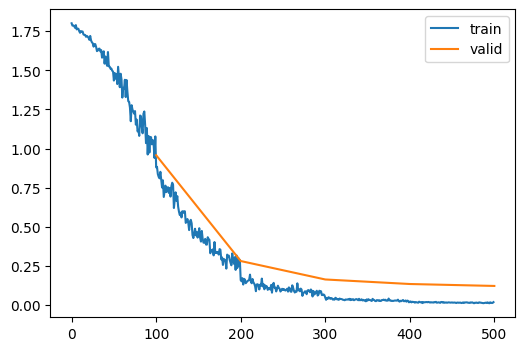

In [24]:
learn1 = TrainLearner(get_model(), dls, lr=.03, loss_func=F.cross_entropy, cbs=cbs)
learn1.fit(5)

accuracy,loss,epoch,train,time
0.521,1.494,0,True,00:00
0.738,1.020,0,False,00:00
0.884,0.543,1,True,00:00
0.942,0.312,1,False,00:00
0.991,0.129,2,True,00:00
0.962,0.175,2,False,00:00
1.000,0.040,3,True,00:00
0.962,0.142,3,False,00:00
1.000,0.020,4,True,00:00
0.963,0.129,4,False,00:00


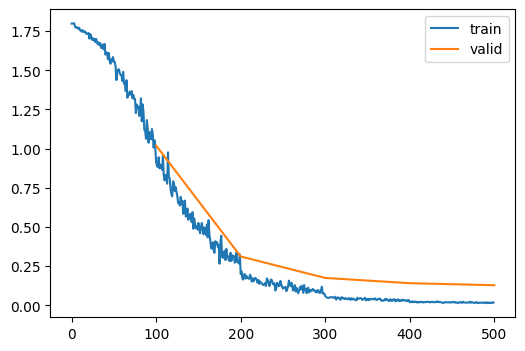

In [25]:
learn2 = TrainLearner(get_model(), dls, lr=.03, loss_func=F.cross_entropy, cbs=cbs)
learn2.fit(5)

accuracy,loss,epoch,train,time
0.514,1.532,0,True,00:00
0.693,1.114,0,False,00:00
0.866,0.631,1,True,00:00
0.946,0.352,1,False,00:00


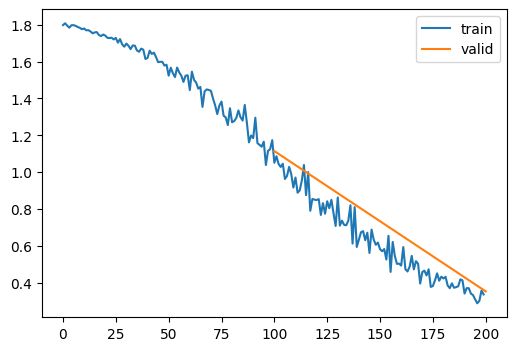

In [26]:
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn1 = TrainLearner(get_model(), dls, lr=.03, loss_func=F.cross_entropy, cbs=cbs)
learn1.fit(2)

In [27]:
cp1 = CapturePreds()
learn1.fit(1, train=False, cbs=cp1)

accuracy,loss,epoch,train,time
0.946,0.352,0,False,00:00


In [28]:
cp2 = CapturePreds()
learn2.fit(1, train=False, cbs=cp2)

accuracy,loss,epoch,train,time
0.963,0.129,0,False,00:00


In [29]:
ap = torch.stack((cp1.all_preds, cp2.all_preds)).mean(0).argmax(1)

In [30]:
round((ap==cp1.all_targs).float().mean().item(), 3)

0.966

In [31]:
cp1 = CapturePreds()
cp2 = CapturePreds()
learn1.dls = DataLoaders((), tst_dl)
learn2.dls = DataLoaders((), tst_dl)
learn1.fit(1, train=False, cbs=cp1)

accuracy,loss,epoch,train,time
0.833,0.438,0,False,00:00


In [32]:
learn2.fit(1, train=False, cbs=cp2)

accuracy,loss,epoch,train,time
0.833,0.381,0,False,00:00


In [33]:
ap = torch.stack((cp1.all_preds, cp2.all_preds)).mean(0).argmax(1)
round((ap==cp1.all_targs).float().mean().item(), 3)

0.833

In [34]:
def ensemble_model(nlearn, get_model = get_model, epochs=5, lr=.03, loss_func=F.cross_entropy, cbs=cbs, opt_func=optim.SGD):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    print('Making inference on test data')
    for learn, cp in zip(learners, cps):
        learn.dls = DataLoaders((), tst_dl)
        learn.fit(1, train=False, cbs=cp)
    ap = torch.stack([cp.all_preds for cp in cps]).mean(0).argmax(1)
    return round((ap==cps[0].all_targs).float().mean().item(), 3)

In [35]:
nlearn = 5

Training models


accuracy,loss,epoch,train,time
0.550,1.444,0,True,00:00
0.747,0.952,0,False,00:00
0.900,0.504,1,True,00:00
0.956,0.298,1,False,00:00
0.992,0.121,2,True,00:00
0.965,0.171,2,False,00:00
1.000,0.038,3,True,00:00
0.967,0.140,3,False,00:00
1.000,0.019,4,True,00:00
0.967,0.126,4,False,00:00


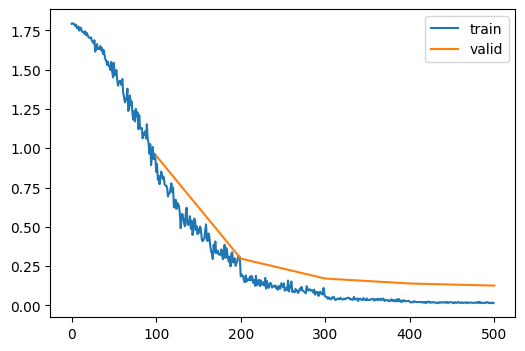

accuracy,loss,epoch,train,time
0.486,1.534,0,True,00:00
0.690,1.123,0,False,00:00
0.859,0.643,1,True,00:00
0.940,0.351,1,False,00:00
0.988,0.154,2,True,00:00
0.962,0.181,2,False,00:00
1.000,0.045,3,True,00:00
0.963,0.145,3,False,00:00
1.000,0.021,4,True,00:00
0.964,0.129,4,False,00:00


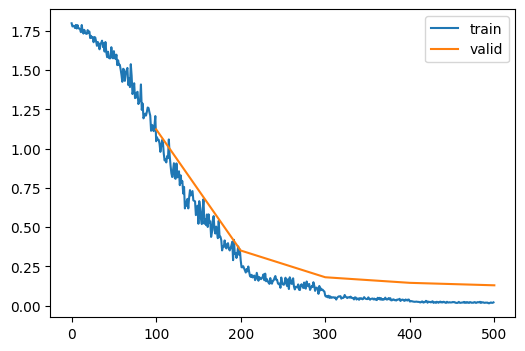

accuracy,loss,epoch,train,time
0.526,1.508,0,True,00:00
0.750,1.068,0,False,00:00
0.907,0.555,1,True,00:00
0.955,0.298,1,False,00:00
0.992,0.121,2,True,00:00
0.966,0.168,2,False,00:00
1.000,0.038,3,True,00:00
0.966,0.135,3,False,00:00
1.000,0.019,4,True,00:00
0.968,0.121,4,False,00:00


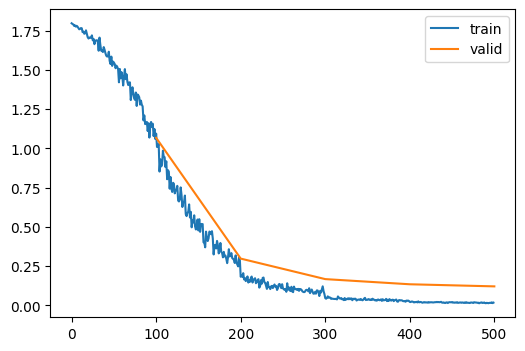

accuracy,loss,epoch,train,time
0.543,1.456,0,True,00:00
0.758,0.959,0,False,00:00
0.914,0.480,1,True,00:00
0.952,0.275,1,False,00:00
0.994,0.107,2,True,00:00
0.960,0.166,2,False,00:00
1.000,0.035,3,True,00:00
0.961,0.137,3,False,00:00
1.000,0.018,4,True,00:00
0.963,0.125,4,False,00:00


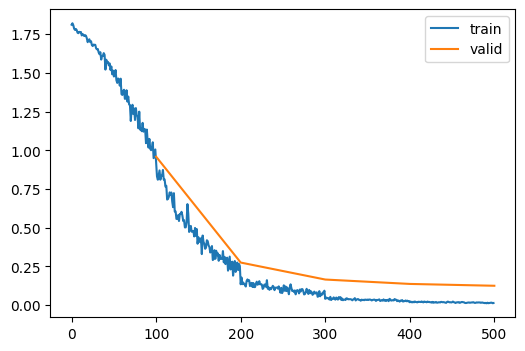

accuracy,loss,epoch,train,time
0.523,1.487,0,True,00:00
0.713,1.032,0,False,00:00
0.880,0.561,1,True,00:00
0.947,0.318,1,False,00:00
0.990,0.135,2,True,00:00
0.963,0.174,2,False,00:00
1.000,0.042,3,True,00:00
0.961,0.141,3,False,00:00
1.000,0.020,4,True,00:00
0.962,0.128,4,False,00:00


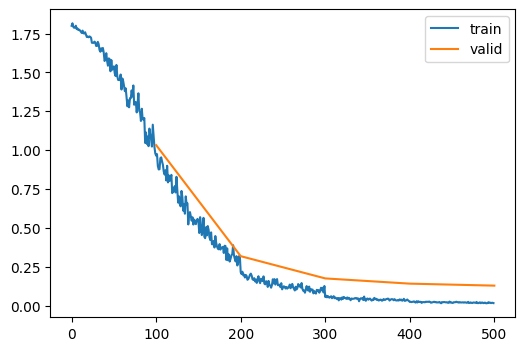

Making inference on test data


accuracy,loss,epoch,train,time
0.833,0.207,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.275,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.378,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.387,0,False,00:00


accuracy,loss,epoch,train,time
0.667,0.363,0,False,00:00


0.833

In [36]:
ensemble_model(nlearn)

Improving the model with parameter initialization, lr_scheduler, and optimizer.

In [37]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

In [38]:
lr, epochs = 6e-3, 5
model = nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 6),
]).apply(init_params)
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [39]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.333,1.901,0,False,00:00


In [40]:
def get_model(): return nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 6),
]).apply(init_params)

Training models


accuracy,loss,epoch,train,time
0.768,0.651,0,True,00:00
0.867,0.353,0,False,00:00
0.977,0.069,1,True,00:00
0.896,0.293,1,False,00:00


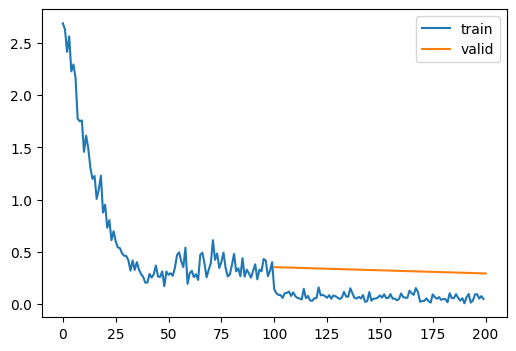

accuracy,loss,epoch,train,time
0.763,0.663,0,True,00:00
0.890,0.314,0,False,00:00
0.973,0.080,1,True,00:00
0.905,0.292,1,False,00:00


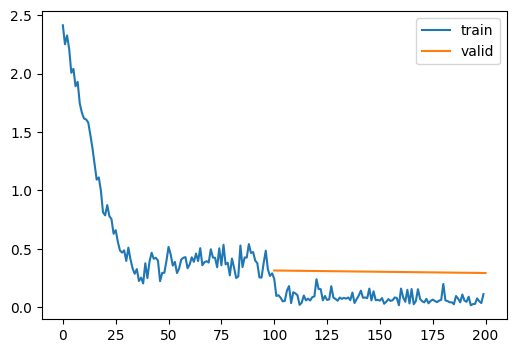

accuracy,loss,epoch,train,time
0.755,0.694,0,True,00:00
0.870,0.336,0,False,00:00
0.971,0.085,1,True,00:00
0.892,0.322,1,False,00:00


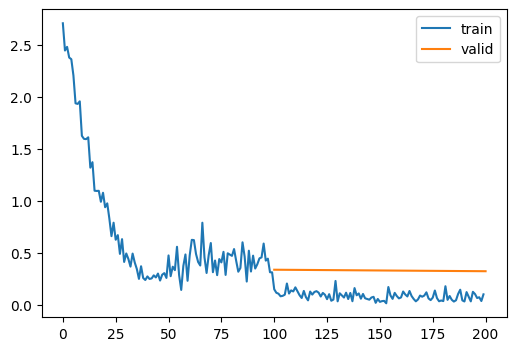

accuracy,loss,epoch,train,time
0.766,0.660,0,True,00:00
0.871,0.361,0,False,00:00
0.972,0.082,1,True,00:00
0.896,0.289,1,False,00:00


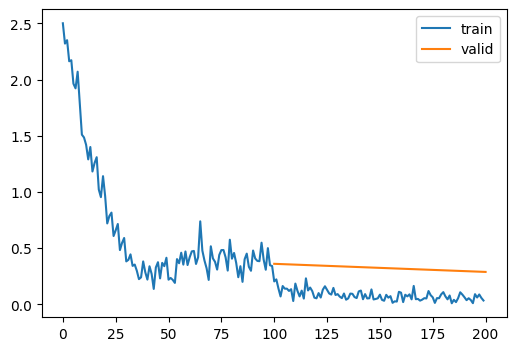

accuracy,loss,epoch,train,time
0.772,0.622,0,True,00:00
0.886,0.320,0,False,00:00
0.975,0.070,1,True,00:00
0.899,0.295,1,False,00:00


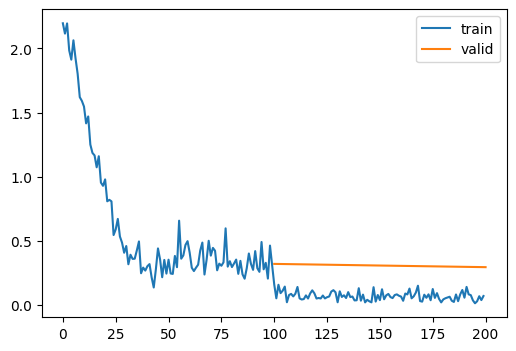

Making inference on test data


accuracy,loss,epoch,train,time
1.000,0.045,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.411,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.501,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.478,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.510,0,False,00:00


0.917

In [41]:
lr, epochs = 6e-3, 2
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.747,0.701,0,True,00:00
0.851,0.428,0,False,00:00
0.959,0.128,1,True,00:00
0.893,0.330,1,False,00:00
0.997,0.011,2,True,00:00
0.899,0.325,2,False,00:00


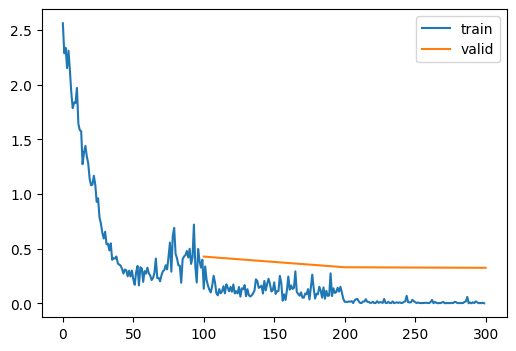

accuracy,loss,epoch,train,time
0.746,0.708,0,True,00:00
0.866,0.413,0,False,00:00
0.962,0.115,1,True,00:00
0.887,0.340,1,False,00:00
0.996,0.012,2,True,00:00
0.895,0.323,2,False,00:00


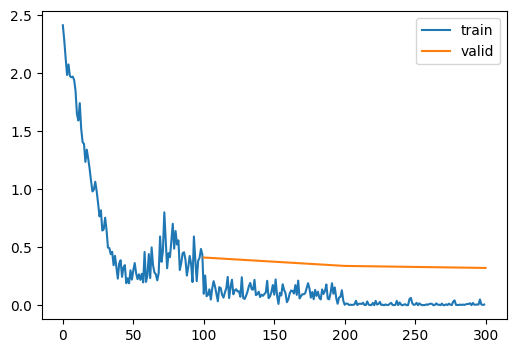

accuracy,loss,epoch,train,time
0.738,0.746,0,True,00:00
0.850,0.416,0,False,00:00
0.957,0.123,1,True,00:00
0.900,0.300,1,False,00:00
0.997,0.013,2,True,00:00
0.904,0.283,2,False,00:00


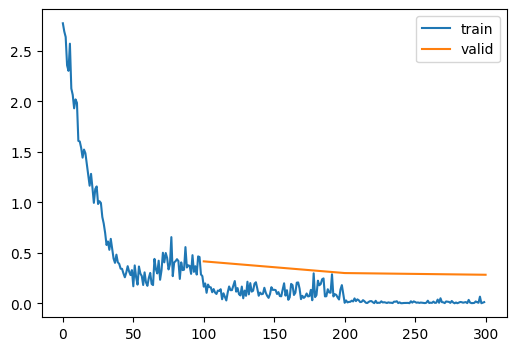

accuracy,loss,epoch,train,time
0.751,0.690,0,True,00:00
0.869,0.359,0,False,00:00
0.962,0.116,1,True,00:01
0.905,0.311,1,False,00:00
0.997,0.010,2,True,00:00
0.912,0.308,2,False,00:00


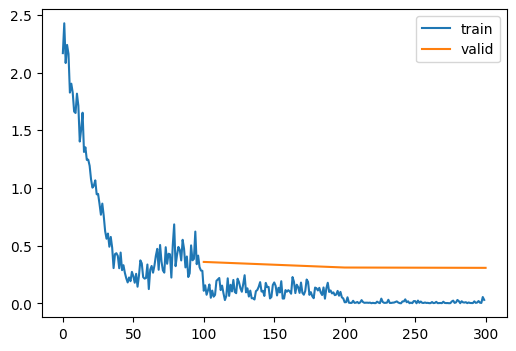

accuracy,loss,epoch,train,time
0.726,0.818,0,True,00:00
0.876,0.371,0,False,00:00
0.962,0.117,1,True,00:00
0.891,0.337,1,False,00:00
0.997,0.010,2,True,00:00
0.898,0.342,2,False,00:00


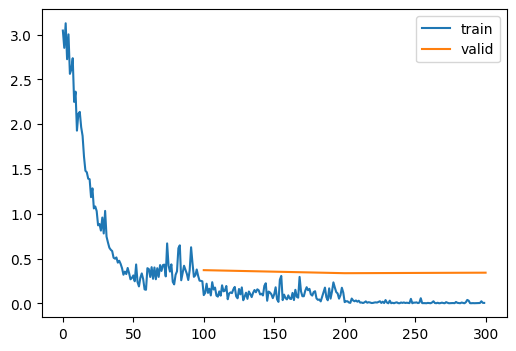

Making inference on test data


accuracy,loss,epoch,train,time
0.917,0.229,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.895,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.178,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.713,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.255,0,False,00:00


0.833

In [42]:
lr, epochs = 6e-3, 3
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.739,0.725,0,True,00:00
0.856,0.417,0,False,00:00
0.947,0.163,1,True,00:00
0.876,0.437,1,False,00:00
0.989,0.034,2,True,00:00
0.895,0.367,2,False,00:00
1.000,0.002,3,True,00:00
0.897,0.372,3,False,00:00


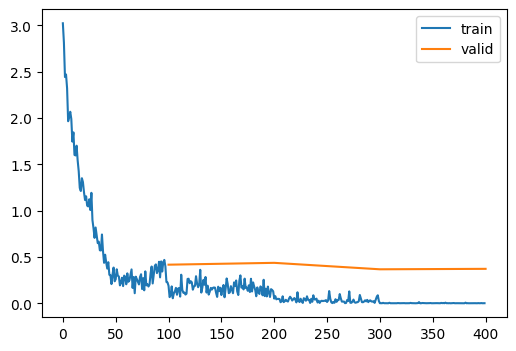

accuracy,loss,epoch,train,time
0.735,0.739,0,True,00:01
0.869,0.380,0,False,00:00
0.951,0.143,1,True,00:01
0.875,0.367,1,False,00:00
0.987,0.041,2,True,00:01
0.897,0.338,2,False,00:00
1.000,0.002,3,True,00:01
0.895,0.340,3,False,00:00


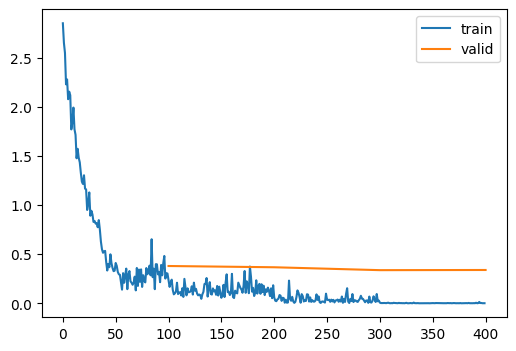

accuracy,loss,epoch,train,time
0.732,0.773,0,True,00:00
0.846,0.424,0,False,00:00
0.950,0.147,1,True,00:00
0.887,0.388,1,False,00:00
0.990,0.033,2,True,00:00
0.893,0.391,2,False,00:00
1.000,0.002,3,True,00:00
0.895,0.385,3,False,00:00


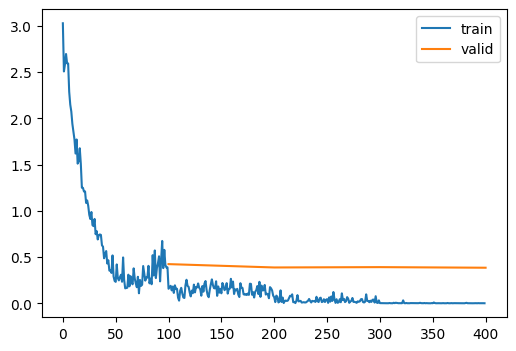

accuracy,loss,epoch,train,time
0.739,0.713,0,True,00:00
0.859,0.409,0,False,00:00
0.950,0.152,1,True,00:00
0.886,0.373,1,False,00:00
0.989,0.031,2,True,00:00
0.894,0.381,2,False,00:00
1.000,0.001,3,True,00:00
0.895,0.378,3,False,00:00


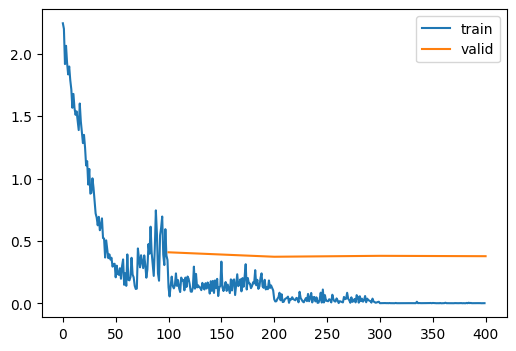

accuracy,loss,epoch,train,time
0.743,0.731,0,True,00:00
0.874,0.375,0,False,00:00
0.953,0.142,1,True,00:01
0.879,0.411,1,False,00:00
0.987,0.041,2,True,00:00
0.899,0.374,2,False,00:00
1.000,0.002,3,True,00:00
0.902,0.365,3,False,00:00


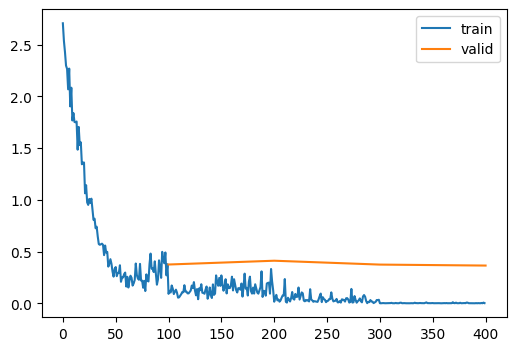

Making inference on test data


accuracy,loss,epoch,train,time
0.583,1.406,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.328,0,False,00:00


accuracy,loss,epoch,train,time
0.583,1.820,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.735,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.633,0,False,00:00


0.75

In [43]:
lr, epochs = 6e-3, 4
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

We train with a lower learning rate.

accuracy,loss,epoch,train,time
0.414,1.543,0,True,00:01
0.746,0.718,0,False,00:00
0.950,0.208,1,True,00:00
0.896,0.293,1,False,00:00
1.000,0.011,2,True,00:00
0.904,0.267,2,False,00:00
1.000,0.005,3,True,00:00
0.905,0.262,3,False,00:00
1.000,0.004,4,True,00:01
0.906,0.261,4,False,00:00


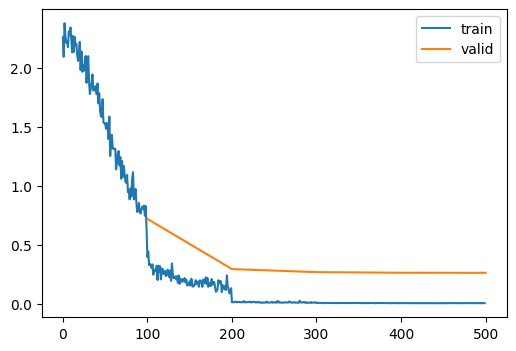

In [44]:
lr, epochs = 6e-4, 5
# set_seed(42)
model = nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 6),
]).apply(init_params)
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [45]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.917,0.129,0,False,00:00


Although the accuracy is very similar, training with lower learning performed much better on the batch data.

Training models


accuracy,loss,epoch,train,time
0.502,1.376,0,True,00:00
0.845,0.453,0,False,00:00
0.974,0.111,1,True,00:00
0.899,0.289,1,False,00:00
1.000,0.014,2,True,00:00
0.904,0.279,2,False,00:00


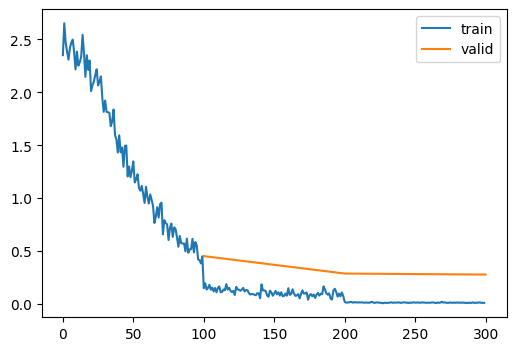

accuracy,loss,epoch,train,time
0.528,1.297,0,True,00:00
0.846,0.436,0,False,00:00
0.975,0.100,1,True,00:00
0.894,0.293,1,False,00:00
1.000,0.012,2,True,00:00
0.897,0.283,2,False,00:00


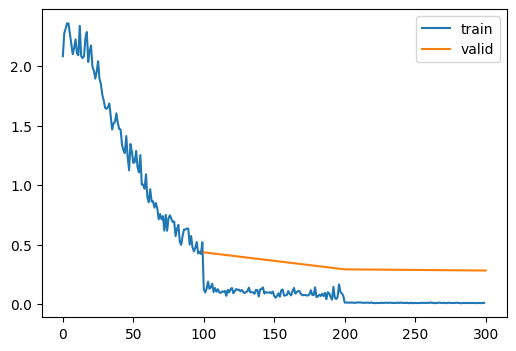

accuracy,loss,epoch,train,time
0.498,1.375,0,True,00:00
0.848,0.445,0,False,00:00
0.976,0.105,1,True,00:00
0.902,0.282,1,False,00:00
1.000,0.012,2,True,00:00
0.905,0.274,2,False,00:00


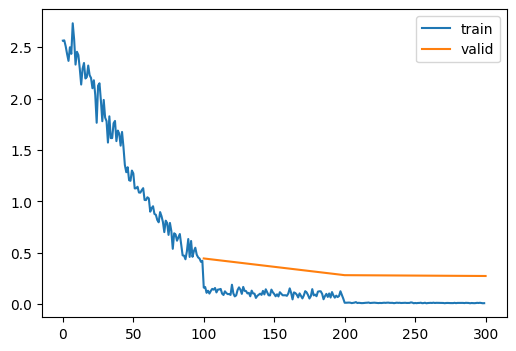

accuracy,loss,epoch,train,time
0.506,1.288,0,True,00:00
0.842,0.436,0,False,00:00
0.974,0.105,1,True,00:00
0.897,0.283,1,False,00:00
1.000,0.011,2,True,00:00
0.898,0.277,2,False,00:00


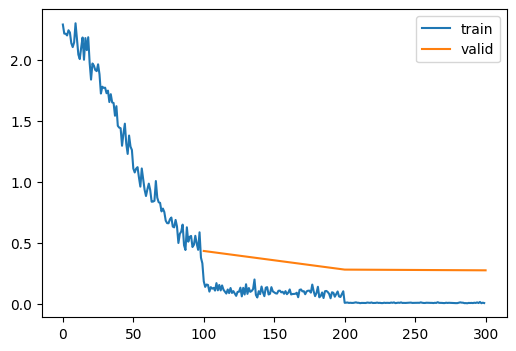

accuracy,loss,epoch,train,time
0.509,1.295,0,True,00:00
0.843,0.451,0,False,00:00
0.976,0.101,1,True,00:01
0.895,0.288,1,False,00:00
1.000,0.011,2,True,00:01
0.901,0.279,2,False,00:00


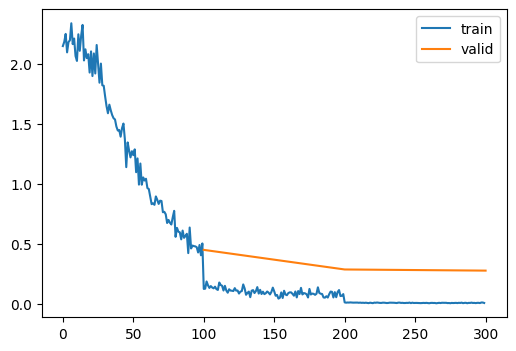

Making inference on test data


accuracy,loss,epoch,train,time
0.917,0.247,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.533,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.632,0,False,00:00


accuracy,loss,epoch,train,time
1.000,0.164,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.498,0,False,00:00


0.833

In [46]:
lr, epochs = 6e-4, 3
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.455,1.436,0,True,00:01
0.811,0.552,0,False,00:00
0.965,0.137,1,True,00:00
0.891,0.304,1,False,00:00
1.000,0.008,2,True,00:00
0.899,0.287,2,False,00:00
1.000,0.005,3,True,00:00
0.899,0.285,3,False,00:00


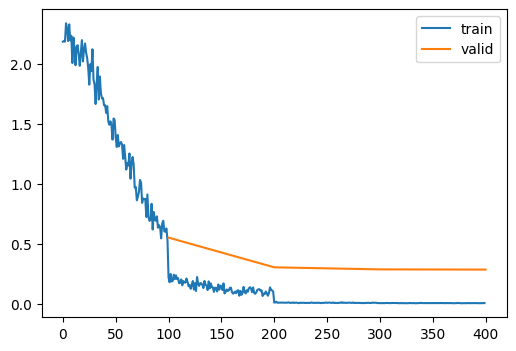

accuracy,loss,epoch,train,time
0.455,1.449,0,True,00:00
0.811,0.575,0,False,00:00
0.963,0.144,1,True,00:00
0.901,0.298,1,False,00:00
1.000,0.009,2,True,00:00
0.903,0.290,2,False,00:00
1.000,0.006,3,True,00:00
0.903,0.289,3,False,00:00


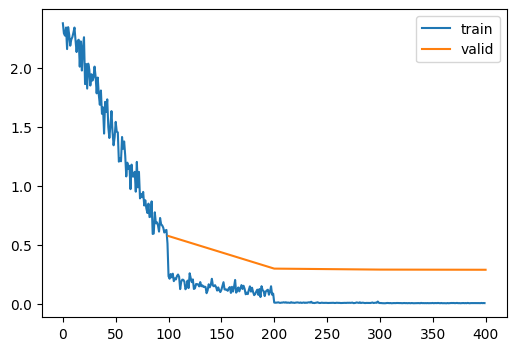

accuracy,loss,epoch,train,time
0.457,1.463,0,True,00:00
0.807,0.572,0,False,00:00
0.965,0.152,1,True,00:00
0.908,0.276,1,False,00:00
1.000,0.009,2,True,00:00
0.912,0.260,2,False,00:00
1.000,0.006,3,True,00:00
0.912,0.258,3,False,00:00


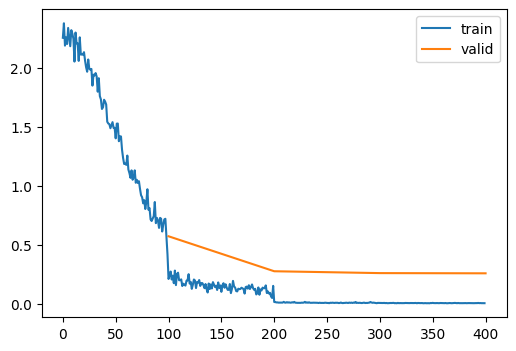

accuracy,loss,epoch,train,time
0.456,1.465,0,True,00:00
0.818,0.550,0,False,00:00
0.966,0.149,1,True,00:01
0.896,0.291,1,False,00:00
1.000,0.010,2,True,00:01
0.905,0.271,2,False,00:00
1.000,0.007,3,True,00:00
0.905,0.269,3,False,00:00


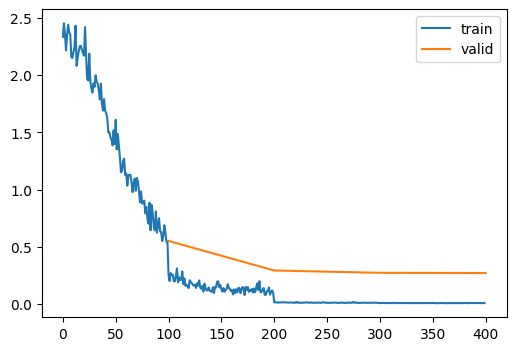

accuracy,loss,epoch,train,time
0.435,1.580,0,True,00:01
0.803,0.573,0,False,00:00
0.963,0.151,1,True,00:00
0.895,0.300,1,False,00:00
1.000,0.010,2,True,00:00
0.903,0.283,2,False,00:00
1.000,0.006,3,True,00:00
0.904,0.281,3,False,00:00


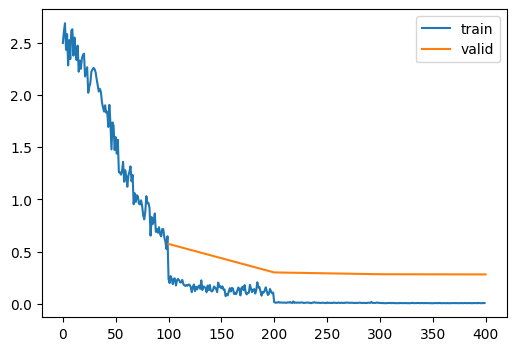

Making inference on test data


accuracy,loss,epoch,train,time
0.917,0.289,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.422,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.326,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.381,0,False,00:00


accuracy,loss,epoch,train,time
0.667,0.817,0,False,00:00


0.833

In [47]:
lr, epochs = 6e-4, 4
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.398,1.739,0,True,00:01
0.744,0.733,0,False,00:00
0.940,0.224,1,True,00:00
0.893,0.312,1,False,00:00
1.000,0.012,2,True,00:00
0.901,0.290,2,False,00:00
1.000,0.006,3,True,00:00
0.898,0.288,3,False,00:00
1.000,0.005,4,True,00:00
0.898,0.287,4,False,00:00


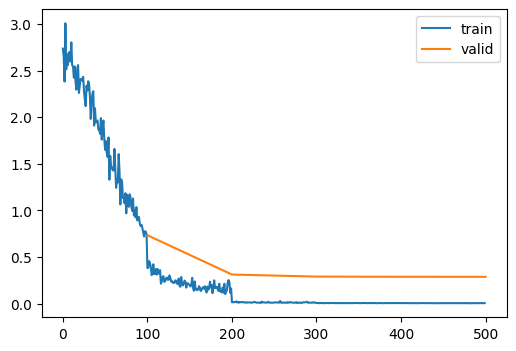

accuracy,loss,epoch,train,time
0.421,1.547,0,True,00:00
0.757,0.685,0,False,00:00
0.953,0.189,1,True,00:00
0.889,0.320,1,False,00:00
1.000,0.010,2,True,00:00
0.899,0.294,2,False,00:00
1.000,0.005,3,True,00:00
0.901,0.290,3,False,00:00
1.000,0.004,4,True,00:01
0.901,0.289,4,False,00:00


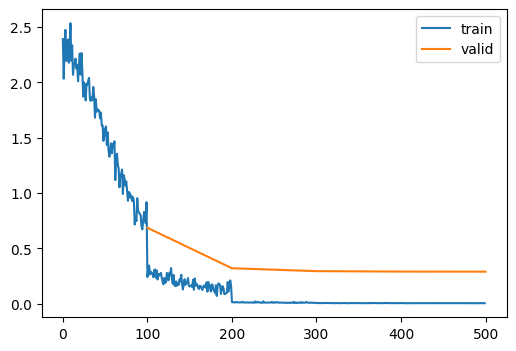

accuracy,loss,epoch,train,time
0.410,1.630,0,True,00:00
0.738,0.737,0,False,00:00
0.950,0.206,1,True,00:00
0.891,0.316,1,False,00:00
1.000,0.011,2,True,00:00
0.900,0.288,2,False,00:00
1.000,0.005,3,True,00:00
0.900,0.283,3,False,00:00
1.000,0.004,4,True,00:00
0.901,0.282,4,False,00:00


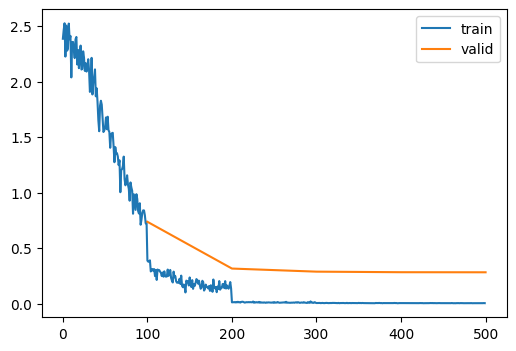

accuracy,loss,epoch,train,time
0.411,1.644,0,True,00:00
0.750,0.730,0,False,00:00
0.947,0.217,1,True,00:00
0.891,0.316,1,False,00:00
1.000,0.012,2,True,00:00
0.902,0.284,2,False,00:00
1.000,0.005,3,True,00:00
0.903,0.281,3,False,00:00
1.000,0.005,4,True,00:00
0.903,0.280,4,False,00:00


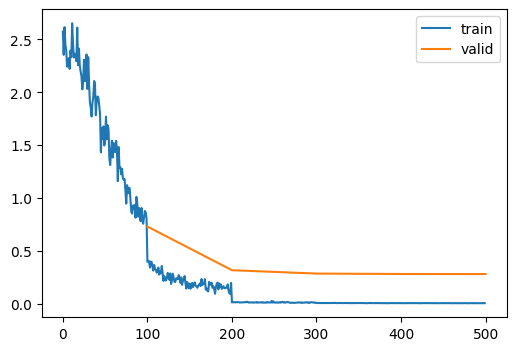

accuracy,loss,epoch,train,time
0.410,1.503,0,True,00:00
0.754,0.714,0,False,00:00
0.952,0.209,1,True,00:00
0.896,0.281,1,False,00:00
1.000,0.010,2,True,00:00
0.903,0.259,2,False,00:00
1.000,0.004,3,True,00:01
0.905,0.257,3,False,00:00
1.000,0.004,4,True,00:01
0.905,0.256,4,False,00:00


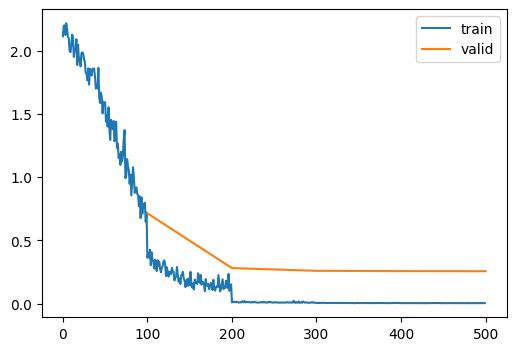

Making inference on test data


accuracy,loss,epoch,train,time
0.917,0.483,0,False,00:00


accuracy,loss,epoch,train,time
0.667,0.460,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.845,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.543,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.244,0,False,00:00


0.833

In [48]:
lr, epochs = 6e-4, 5
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Dropout

accuracy,loss,epoch,train,time
0.263,2.967,0,True,00:00
0.708,0.870,0,False,00:00
0.630,1.050,1,True,00:00
0.888,0.368,1,False,00:00
0.818,0.499,2,True,00:00
0.917,0.252,2,False,00:00
0.874,0.340,3,True,00:00
0.927,0.219,3,False,00:00
0.898,0.272,4,True,00:00
0.927,0.215,4,False,00:00


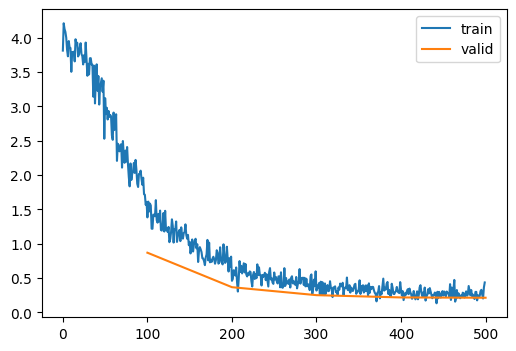

In [49]:
lr, epochs = 1e-3, 5
# set_seed(42)
model = nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 6),
]).apply(init_params)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn1 = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn1.fit(epochs)

In [50]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.917,0.129,0,False,00:00


In [51]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 6),
]).apply(init_params)

Training models


accuracy,loss,epoch,train,time
0.361,2.319,0,True,00:01
0.816,0.593,0,False,00:00
0.687,0.856,1,True,00:00
0.874,0.443,1,False,00:00


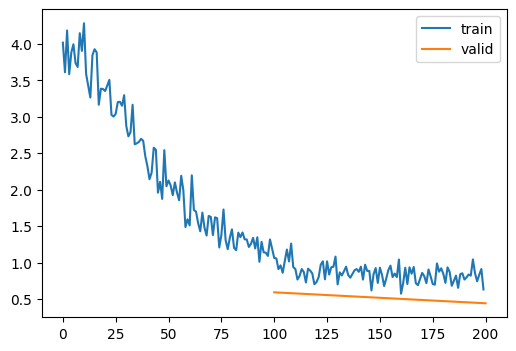

accuracy,loss,epoch,train,time
0.354,2.321,0,True,00:00
0.808,0.601,0,False,00:00
0.691,0.817,1,True,00:00
0.867,0.457,1,False,00:00


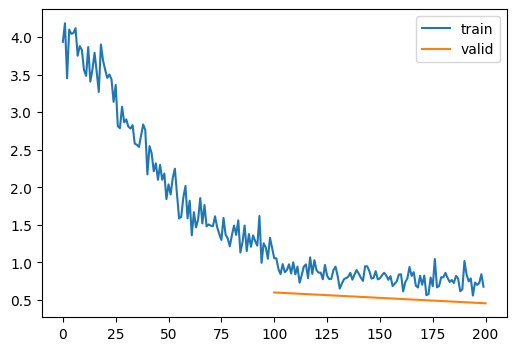

accuracy,loss,epoch,train,time
0.353,2.543,0,True,00:00
0.794,0.622,0,False,00:00
0.673,0.915,1,True,00:00
0.852,0.477,1,False,00:00


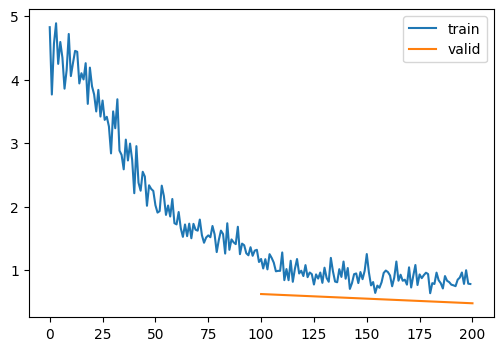

accuracy,loss,epoch,train,time
0.360,2.349,0,True,00:00
0.794,0.611,0,False,00:00
0.679,0.882,1,True,00:00
0.857,0.469,1,False,00:00


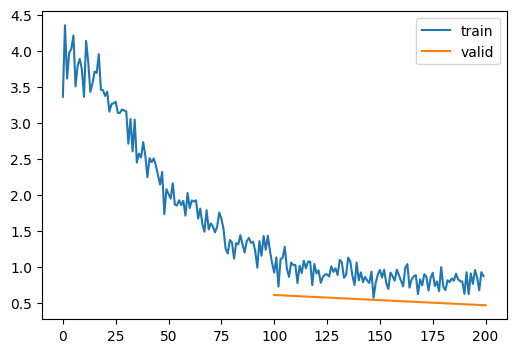

accuracy,loss,epoch,train,time
0.360,2.181,0,True,00:00
0.810,0.620,0,False,00:00
0.686,0.842,1,True,00:00
0.868,0.462,1,False,00:00


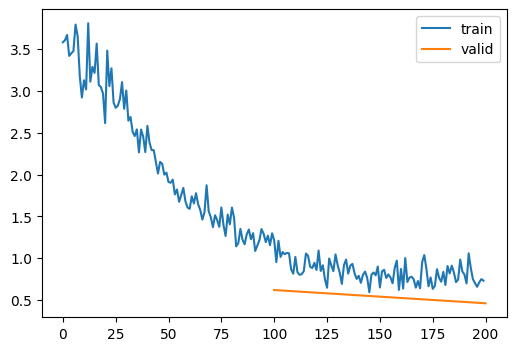

Making inference on test data


accuracy,loss,epoch,train,time
0.750,0.434,0,False,00:00


accuracy,loss,epoch,train,time
0.583,0.893,0,False,00:00


accuracy,loss,epoch,train,time
0.583,0.693,0,False,00:00


accuracy,loss,epoch,train,time
0.583,0.653,0,False,00:00


accuracy,loss,epoch,train,time
0.667,0.496,0,False,00:00


0.75

In [52]:
lr, epochs = 1e-3, 2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.317,2.602,0,True,00:00
0.783,0.641,0,False,00:00
0.695,0.837,1,True,00:00
0.894,0.354,1,False,00:00
0.801,0.525,2,True,00:00
0.903,0.321,2,False,00:00


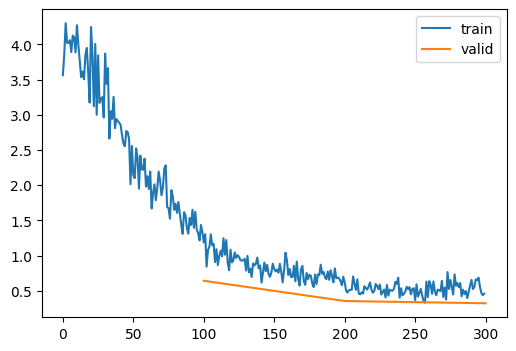

accuracy,loss,epoch,train,time
0.332,2.260,0,True,00:00
0.773,0.711,0,False,00:00
0.694,0.824,1,True,00:00
0.896,0.366,1,False,00:00
0.810,0.508,2,True,00:01
0.905,0.328,2,False,00:00


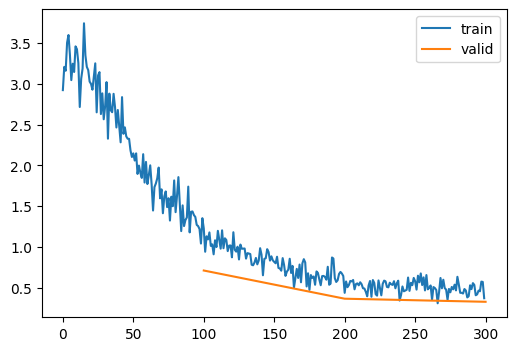

accuracy,loss,epoch,train,time
0.308,2.549,0,True,00:00
0.774,0.724,0,False,00:00
0.670,0.897,1,True,00:00
0.897,0.362,1,False,00:00
0.797,0.554,2,True,00:00
0.910,0.319,2,False,00:00


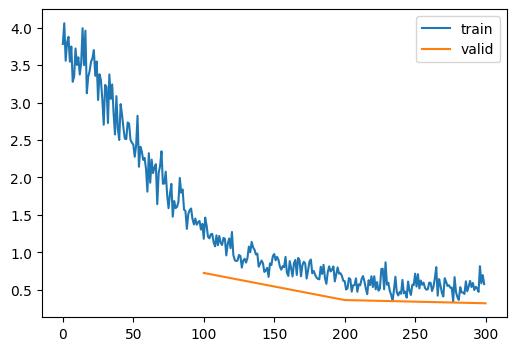

accuracy,loss,epoch,train,time
0.340,2.465,0,True,00:00
0.788,0.634,0,False,00:00
0.696,0.826,1,True,00:00
0.896,0.347,1,False,00:00
0.810,0.504,2,True,00:00
0.904,0.315,2,False,00:00


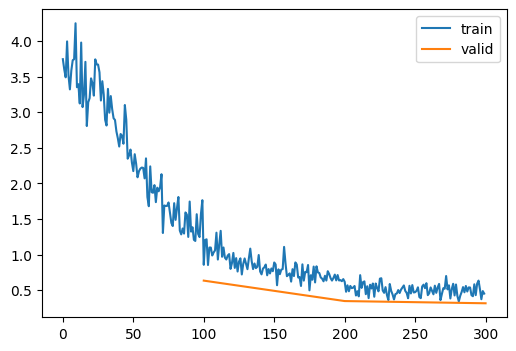

accuracy,loss,epoch,train,time
0.311,2.647,0,True,00:00
0.771,0.690,0,False,00:00
0.684,0.876,1,True,00:00
0.899,0.365,1,False,00:00
0.800,0.546,2,True,00:00
0.907,0.330,2,False,00:00


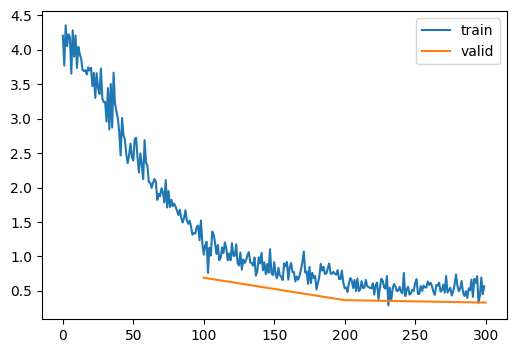

Making inference on test data


accuracy,loss,epoch,train,time
0.833,0.317,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.335,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.326,0,False,00:00


accuracy,loss,epoch,train,time
0.667,0.406,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.341,0,False,00:00


0.833

In [53]:
lr, epochs = 1e-3, 3
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.286,2.665,0,True,00:00
0.742,0.778,0,False,00:00
0.653,0.947,1,True,00:00
0.899,0.365,1,False,00:00
0.811,0.505,2,True,00:00
0.925,0.265,2,False,00:00
0.858,0.384,3,True,00:00
0.926,0.252,3,False,00:00


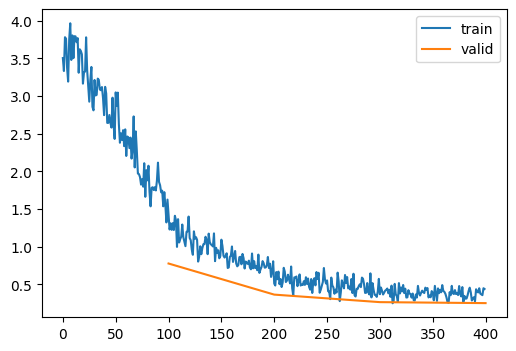

accuracy,loss,epoch,train,time
0.283,2.797,0,True,00:00
0.720,0.830,0,False,00:00
0.641,0.970,1,True,00:00
0.897,0.372,1,False,00:00
0.809,0.512,2,True,00:00
0.927,0.268,2,False,00:00
0.861,0.372,3,True,00:00
0.929,0.252,3,False,00:00


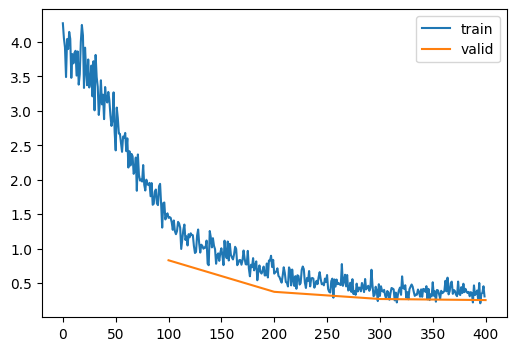

accuracy,loss,epoch,train,time
0.292,2.738,0,True,00:00
0.725,0.793,0,False,00:00
0.652,0.987,1,True,00:01
0.886,0.388,1,False,00:00
0.802,0.525,2,True,00:01
0.912,0.290,2,False,00:00
0.853,0.406,3,True,00:01
0.919,0.277,3,False,00:00


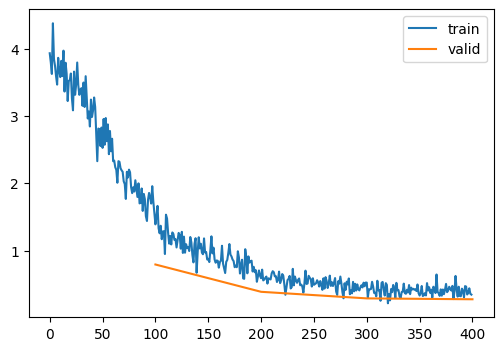

accuracy,loss,epoch,train,time
0.278,2.692,0,True,00:00
0.733,0.797,0,False,00:00
0.647,0.959,1,True,00:00
0.903,0.344,1,False,00:00
0.813,0.494,2,True,00:00
0.929,0.250,2,False,00:00
0.859,0.366,3,True,00:00
0.932,0.238,3,False,00:00


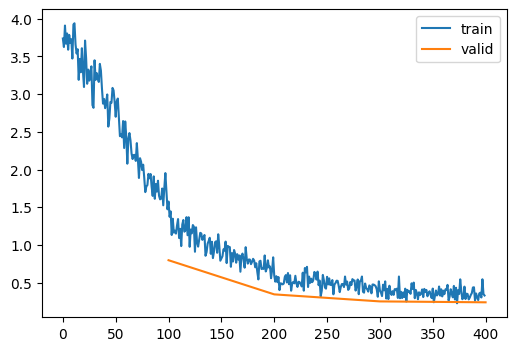

accuracy,loss,epoch,train,time
0.280,3.218,0,True,00:00
0.745,0.741,0,False,00:00
0.650,1.027,1,True,00:00
0.885,0.358,1,False,00:00
0.801,0.550,2,True,00:00
0.912,0.273,2,False,00:00
0.855,0.408,3,True,00:00
0.916,0.261,3,False,00:00


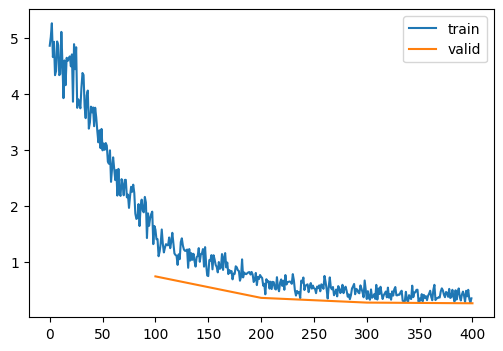

Making inference on test data


accuracy,loss,epoch,train,time
0.833,0.373,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.391,0,False,00:00


accuracy,loss,epoch,train,time
0.667,0.752,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.592,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.565,0,False,00:00


0.75

In [54]:
lr, epochs = 1e-3, 4
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.248,3.141,0,True,00:00
0.687,0.882,0,False,00:00
0.623,1.070,1,True,00:00
0.882,0.372,1,False,00:00
0.816,0.503,2,True,00:00
0.921,0.248,2,False,00:00
0.886,0.315,3,True,00:00
0.929,0.218,3,False,00:00
0.902,0.264,4,True,00:00
0.931,0.213,4,False,00:00


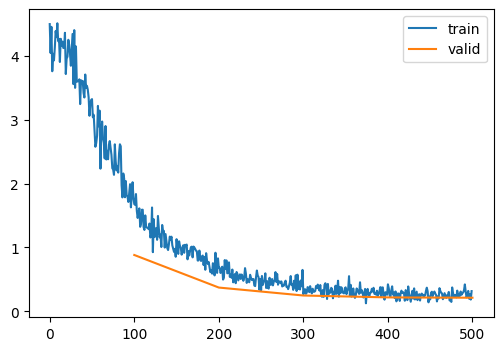

accuracy,loss,epoch,train,time
0.257,3.254,0,True,00:00
0.667,0.924,0,False,00:00
0.623,1.104,1,True,00:00
0.888,0.385,1,False,00:00
0.804,0.541,2,True,00:00
0.923,0.252,2,False,00:00
0.869,0.354,3,True,00:00
0.932,0.218,3,False,00:00
0.893,0.288,4,True,00:00
0.933,0.212,4,False,00:00


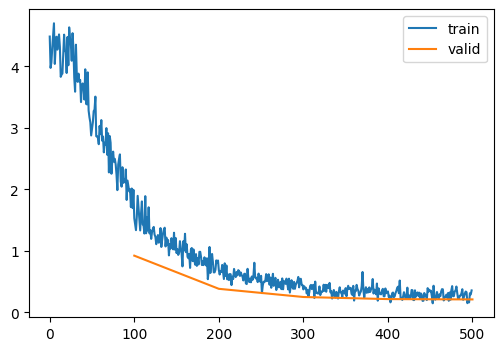

accuracy,loss,epoch,train,time
0.263,3.009,0,True,00:00
0.693,0.870,0,False,00:00
0.615,1.124,1,True,00:00
0.882,0.389,1,False,00:00
0.795,0.558,2,True,00:01
0.925,0.253,2,False,00:00
0.875,0.345,3,True,00:00
0.935,0.214,3,False,00:00
0.901,0.274,4,True,00:00
0.937,0.209,4,False,00:00


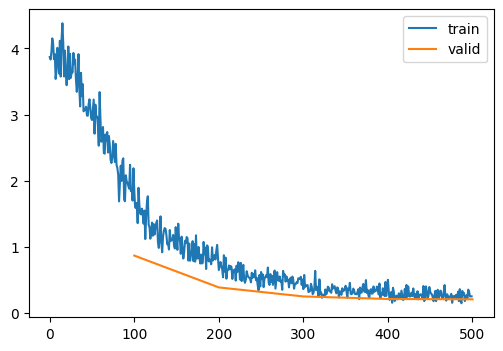

accuracy,loss,epoch,train,time
0.256,3.274,0,True,00:00
0.689,0.859,0,False,00:00
0.626,1.062,1,True,00:00
0.882,0.380,1,False,00:00
0.806,0.533,2,True,00:00
0.914,0.261,2,False,00:00
0.871,0.347,3,True,00:00
0.925,0.224,3,False,00:00
0.891,0.295,4,True,00:00
0.927,0.219,4,False,00:00


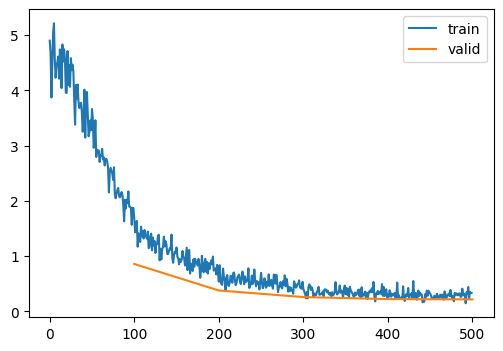

accuracy,loss,epoch,train,time
0.256,2.965,0,True,00:00
0.667,0.916,0,False,00:00
0.594,1.150,1,True,00:00
0.873,0.430,1,False,00:00
0.791,0.572,2,True,00:00
0.914,0.285,2,False,00:00
0.862,0.371,3,True,00:00
0.925,0.237,3,False,00:00
0.887,0.303,4,True,00:00
0.930,0.230,4,False,00:00


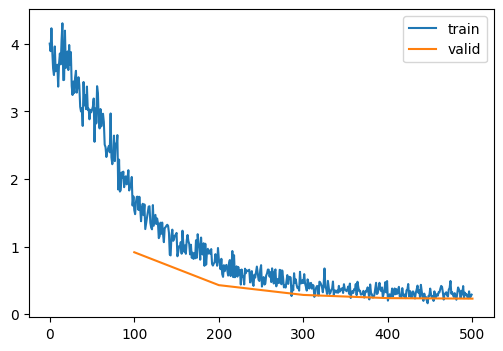

Making inference on test data


accuracy,loss,epoch,train,time
0.750,0.622,0,False,00:00


accuracy,loss,epoch,train,time
0.583,0.753,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.484,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.493,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.502,0,False,00:00


0.667

In [55]:
lr, epochs = 1e-3, 5
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Batchnorm

In [56]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 6),
    nn.BatchNorm1d(6)
]).apply(init_params)

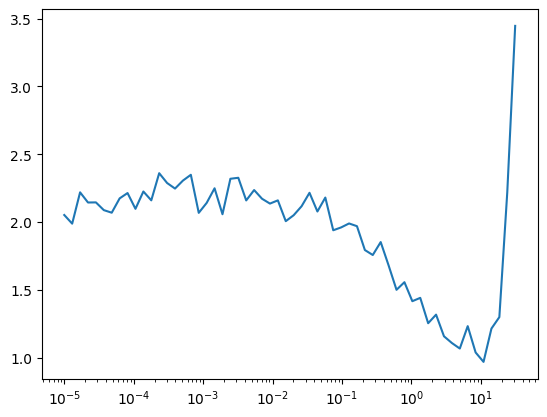

In [57]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

Training models


accuracy,loss,epoch,train,time
0.670,0.857,0,True,00:00
0.885,0.343,0,False,00:00
0.857,0.408,1,True,00:00
0.933,0.227,1,False,00:00


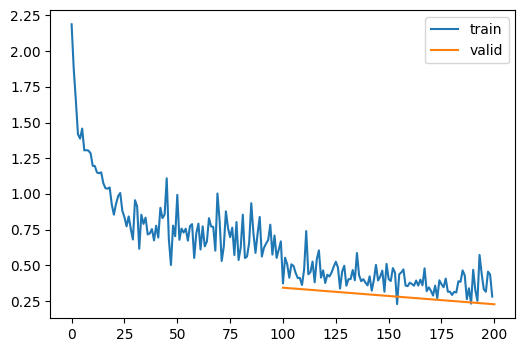

accuracy,loss,epoch,train,time
0.676,0.838,0,True,00:00
0.893,0.322,0,False,00:00
0.854,0.408,1,True,00:00
0.933,0.208,1,False,00:00


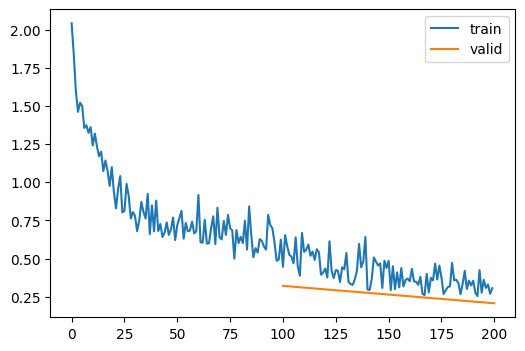

accuracy,loss,epoch,train,time
0.682,0.836,0,True,00:00
0.853,0.414,0,False,00:00
0.860,0.388,1,True,00:00
0.923,0.233,1,False,00:00


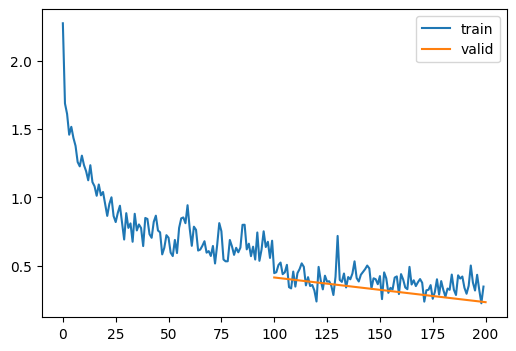

accuracy,loss,epoch,train,time
0.686,0.813,0,True,00:00
0.907,0.272,0,False,00:00
0.871,0.368,1,True,00:00
0.945,0.198,1,False,00:00


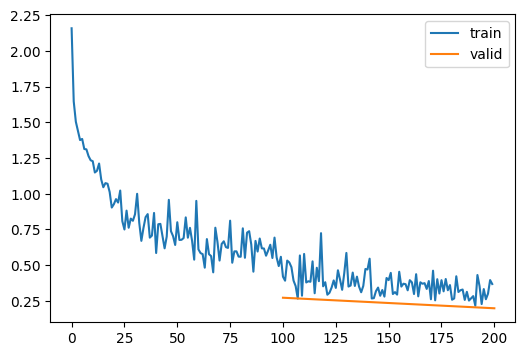

accuracy,loss,epoch,train,time
0.673,0.861,0,True,00:00
0.869,0.355,0,False,00:00
0.867,0.380,1,True,00:00
0.931,0.225,1,False,00:00


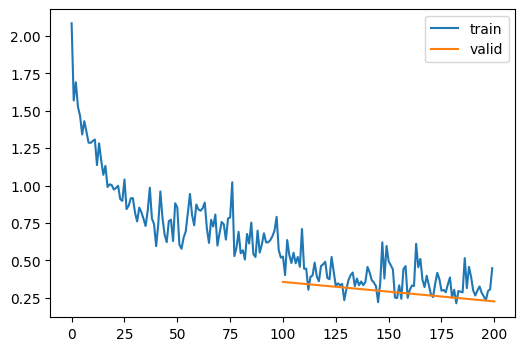

Making inference on test data


accuracy,loss,epoch,train,time
0.750,0.315,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.302,0,False,00:00


accuracy,loss,epoch,train,time
1.000,0.178,0,False,00:00


accuracy,loss,epoch,train,time
0.667,0.469,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.328,0,False,00:00


0.833

In [59]:
lr, epochs = 1, 2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Conclusion

Unfortunately, deeper network did not perform better on bulk data than shallower network even if they did better on scRNA-seq data. Maybe because the training data is too noisy with random numbers.